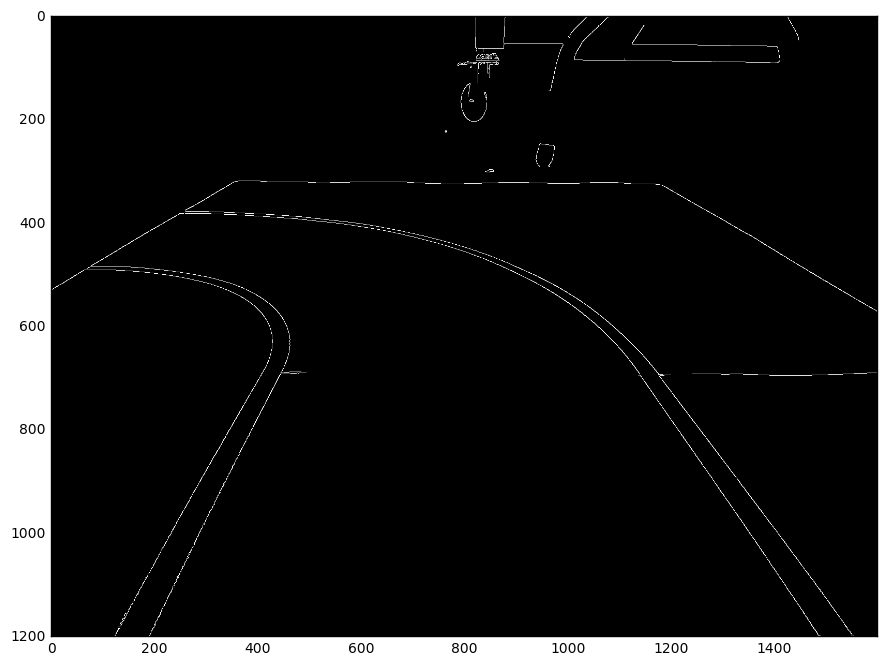

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
from sklearn import linear_model


%matplotlib inline 
matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)

img_bgr = cv2.imread('../pics/phone2.jpeg',1)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_height = img_rgb.shape[0]
img_width = img_rgb.shape[1]
#img_rgb2 = img_

# # First, transform to greyscale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(img_rgb, 11, 17, 17)

# # Apply a Canny filter to pick out edges
edged = cv2.Canny(gray, 50, 200, apertureSize = 3)

plt.imshow(edged, cmap = "Greys_r")



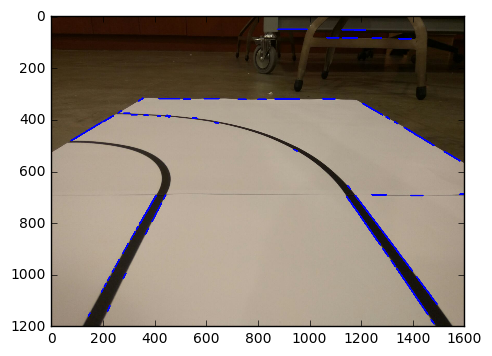

In [2]:
# Apply a probabilistic Hough transform to the image
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edged, 1, np.pi/180, 100, minLineLength, maxLineGap)

# De-nest the list one level (for some reason, each set of points is in a nested list)
lines = list([l[0] for l in lines])

if lines is not None:
    for x1, y1, x2, y2 in lines:
        cv2.line(img_rgb, (x1, y1),(x2, y2), (0, 0, 255), 5)
    
plt.imshow(img_rgb)

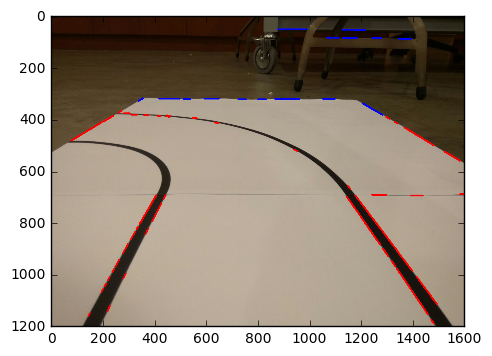

In [3]:
# Filter out those lines above the horizon
horizon_threshold = 0.3 * img_height
lines_filtered = list(filter(lambda x: x[1]>horizon_threshold and x[3] > horizon_threshold, lines))
    
# Filter out lines that are too close to horizontal
theta_threshold = 0.25

def get_theta(x):
    x1, y1, x2, y2 = x
    return np.abs(np.arctan2((y2-y1), (x2-x1)))

#lines_filtered = list(filter(lambda x: get_theta(x) > theta_threshold, lines_filtered))  # line angle WRT horizon

for x1, y1, x2, y2 in lines_filtered:
    cv2.line(img_rgb, (x1, y1),(x2, y2), (255, 0, 0), 5)

plt.imshow(img_rgb)

Now, we will split the points up into two groups, the left and the right lane, and find the equation of the line for each

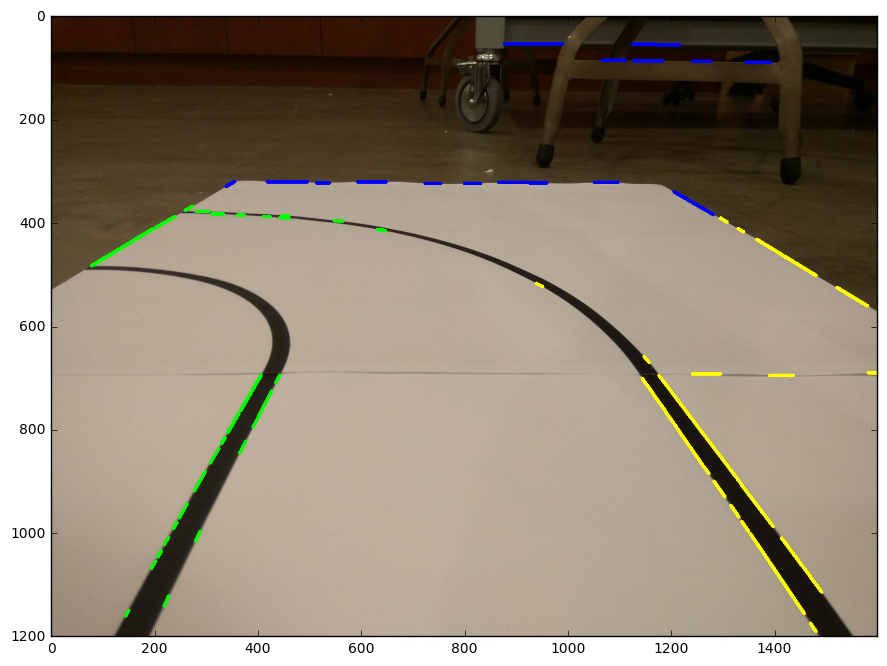

In [4]:
centre_x = img_bgr.shape[1] / 2

# Get all the lines that have an average x value to the left of centre, and same for right
lines_left = list(filter(lambda x: (x[0] + x[2]) / 2 < centre_x, lines_filtered))
lines_right = list(filter(lambda x: (x[0] + x[2]) / 2 >= centre_x, lines_filtered))

for x1, y1, x2, y2 in lines_left:
    cv2.line(img_rgb, (x1, y1),(x2, y2), (0, 255, 0), 5)

for x1, y1, x2, y2 in lines_right:
    cv2.line(img_rgb, (x1, y1),(x2, y2), (255, 255, 0), 5)

matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
plt.imshow(img_rgb)

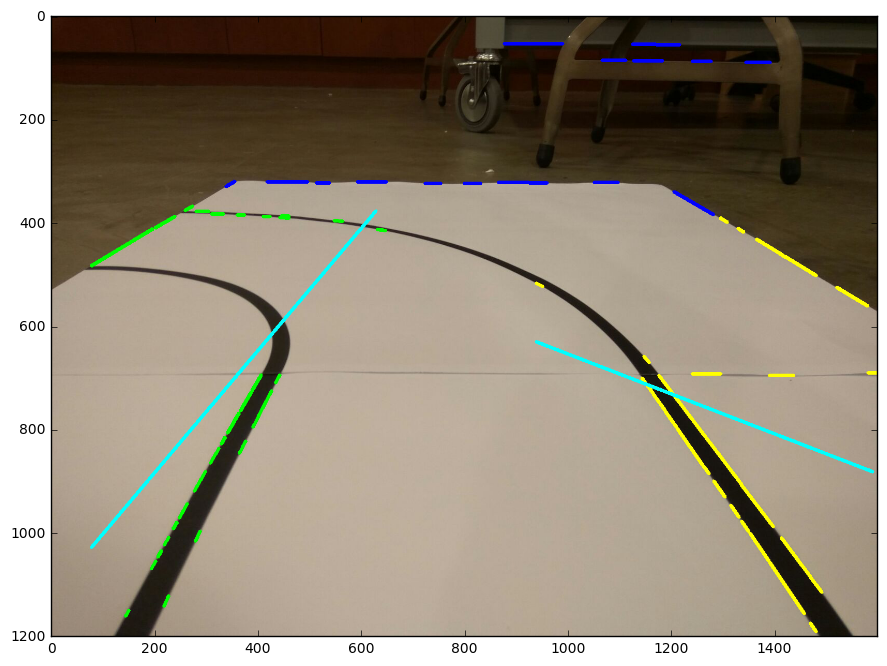

In [5]:
        
# Fancy list comprehension - get the elements at even positions in the sublists and flatten into one 
lines_left_x = np.transpose(np.asarray([[item for sublist in lines_left for item in sublist[0::2]]]))
lines_left_y = np.transpose(np.asarray([[item for sublist in lines_left for item in sublist[1::2]]]))

lines_right_x = np.transpose(np.asarray([[item for sublist in lines_right for item in sublist[0::2]]]))
lines_right_y = np.transpose(np.asarray([[item for sublist in lines_right for item in sublist[1::2]]]))

# Fit line using Linear Regression
model = linear_model.LinearRegression()
model.fit(lines_left_x, lines_left_y)

line_x = np.arange(min(lines_left_x)[0], max(lines_left_x)[0], 50)
line_y = model.predict(line_x[:, np.newaxis])
cv2.line(img_rgb, (line_x[0], line_y[0]),(line_x[-1], line_y[-1]), (0, 255, 255), 5)

model.fit(lines_right_x, lines_right_y)
line_x2 = np.arange(min(lines_right_x)[0], max(lines_right_x)[0], 50)
line_y2 = model.predict(line_x2[:, np.newaxis])
cv2.line(img_rgb, (line_x2[0], line_y2[0]),(line_x2[-1], line_y2[-1]), (0, 255, 255), 5)  

# # Fit line using RANSAC
# model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
# model_ransac.fit(lines_left_x, lines_left_y)

# line_x = np.arange(min(lines_left_x)[0], max(lines_left_x)[0], 50)
# line_y = model_ransac.predict(line_x[:, np.newaxis])
# cv2.line(img_rgb, (line_x[0], line_y[0]),(line_x[-1], line_y[-1]), (255, 255, 255), 5)

# m_left = model_ransac.estimator_.coef_
# c_left = model_ransac.estimator_.intercept_

# left_lane = (model_ransac.estimator_.coef_, model_ransac.estimator_.intercept_)

# model_ransac.fit(lines_right_x, lines_right_y)

# right_lane = (model_ransac.estimator_.coef_, model_ransac.estimator_.intercept_)

# line_x2 = np.arange(min(lines_right_x)[0], max(lines_right_x)[0], 50)
# line_y2 = model_ransac.predict(line_x2[:, np.newaxis])
# cv2.line(img_rgb, (line_x2[0], line_y2[0]),(line_x2[-1], line_y2[-1]), (255, 255, 255), 5)        

plt.imshow(img_rgb)

In [ ]:
model = linear_model.LinearRegression()
model.fit(lines_left_x, lines_left_y)

line_x = np.arange(min(lines_left_x)[0], max(lines_left_x)[0], 50)
line_y = model.predict(line_x[:, np.newaxis])
cv2.line(img_rgb, (line_x[0], line_y[0]),(line_x[-1], line_y[-1]), (255, 255, 255), 5)

In [ ]:
# Find equation of center line

m_right = model_ransac.estimator_.coef_
c_right = model_ransac.estimator_.intercept_

intersection_x = (c_left - c_right) / (m_right - m_left)
intersection_y = m_left * intersection_x + c_left

m_mid = np.tan((np.arctan(m_right) + np.arctan(m_left) - np.pi) / 2 ) 
c_mid = intersection_y - m_mid * intersection_x

mid_lane = (m_mid, c_mid)

x_bottom = (img_height - c_mid) / m_mid
#x_300 = (300 - c_mid) / m_mid

# cv2.line(img_rgb, (intersection_x, intersection_y),(x_bottom, 1200), (255, 255, 255), 5)
matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)

plt.imshow(img_rgb)

print(m_left, m_mid, m_right)
print(c_left, c_mid, c_right)
print(intersection_x, intersection_y)


In [ ]:
horizon_threshold = 0.333

x_horiz_left = int((img_rgb.shape[0] * horizon_threshold - left_lane[1]) / left_lane[0])
x_bottom_left = int((img_rgb.shape[0] - left_lane[1]) / left_lane[0])
cv2.line(img_rgb, (x_horiz_left, int(img_rgb.shape[0] * horizon_threshold)), (x_bottom_left, img_rgb.shape[0]), \
         (255, 255, 255), 5)

x_horiz_right = int((img_rgb.shape[0] * horizon_threshold - right_lane[1]) / right_lane[0])
x_bottom_right = int((img_rgb.shape[0] - right_lane[1]) / right_lane[0])
cv2.line(img_rgb, (x_horiz_right,int(img_rgb.shape[0] * horizon_threshold)), (x_bottom_right, img_rgb.shape[0]), \
        (255, 255, 255), 5)                     

x_horiz_mid = int((img_rgb.shape[0] * horizon_threshold - mid_lane[1]) / mid_lane[0])
x_bottom_mid = int((img_rgb.shape[0] - mid_lane[1]) / mid_lane[0])
cv2.line(img_rgb, (x_horiz_mid, int(img_rgb.shape[0] * horizon_threshold)), (x_bottom_mid, img_rgb.shape[0]), \
        (255, 255, 255), 5) 

plt.imshow(img_rgb)

In [ ]:
def scale_line(x1, y1, x2, y2, road_horizon, frame_height):
    # scale the farthest point of the segment to be on the drawing horizon
    if x1 == x2:
        if y1 < y2:
            y1 = road_horizon
            y2 = frame_height
            return x1, y1, x2, y2
        else:
            y2 = road_horizon
            y1 = frame_height
            return x1, y1, x2, y2
    if y1 < y2:
        m = (y1-y2)/(x1-x2)
        x1 = ((road_horizon-y1)/m) + x1
        y1 = road_horizon
        x2 = ((frame_height-y2)/m) + x2
        y2 = frame_height
    else:
        m = (y2-y1)/(x2-x1)
        x2 = ((road_horizon-y2)/m) + x2
        y2 = road_horizon
        x1 = ((frame_height-y1)/m) + x1
        y1 = frame_height
    return x1, y1, x2, y2

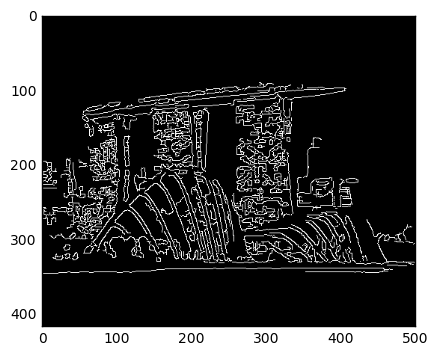

In [2]:
# img_puppy_bgr = cv2.imread('../pics/puppies.jpg',0)
# img_puppy = cv2.cvtColor(img_puppy_bgr, cv2.COLOR_BGR2RGB)
# blur = cv2.GaussianBlur(img_puppy, (7, 7), 100)

mbs = cv2.imread('../pics/mbs.jpg',0)[:, 150:650]
blur = cv2.GaussianBlur(mbs, (5,5), 10)

sobelx = cv2.Sobel(blur,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(blur,cv2.CV_64F,0,1,ksize=5)

edged = cv2.Canny(blur, 50, 200, apertureSize = 3)

plt.imshow(edged, cmap = "gray")
